# How to solve H(div) PDEs in practice?

This document explores the current, **easily accessible**, state of the art for solving an $H(\rm div) \times L^2$ formulation of Poisson's problem or equivalently Darcy flow using FEniCS (www.fenicsproject.org) and underlying linear algebra libraries e.g. PETSc.

## Mathematical background

### Poisson's equation
The underlying PDE in question is: given $f$, find $p$ satisfying

  $- \Delta p = f$ 

over a computational domain $\Omega$ with homogeneous Dirichlet boundary conditions where $\Delta$ is the standard Laplace operator.

### Primal formulation
The standard (primal) $H^1$ formulation of this problem reads as: find $p \in H^1_0$ such that

  $\int_{\Omega} \nabla p \cdot \nabla q \, \textrm{d} x = \int_{\Omega} f q \, \textrm{d} x$

for all $q \in H^1_0$. Usual finite element spaces for this formulation is for instance Lagrange elements of order $k \geq 1$ i.e. continuous piecewise polynomials of polynomial order $k$ defined relative to a mesh of the domain.

### Mixed formulation
The standard (mixed) $H(\rm div) \times L^2$ formulation of this problem reads as: find $u \in H(\rm div)$ and $p \in L^2$ such that

  $\int_{\Omega} u \cdot v + \nabla \cdot u q + \nabla \cdot v p \, \textrm{d} x = \int_{\Omega} - f q \, \textrm{d} x$ 

Stable finite elements for this formulation is for instance Raviart-Thomas elements of order $k+1$ and discontinuous elements of order $k$ for $k \geq 0$. 


## Implementation basics 

Premises for this notebook:
* The implementation should be accessible through the Python interface to the FEniCS software

In [1]:
# Import useful libraries
from dolfin import *
import numpy
import pylab

# Plot inline in this notebook
%matplotlib inline

# Set basic optimization parameters for FEniCS
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["cpp_optimize"] = True
#parameters["plotting_backend"] = "matplotlib"

Some code snippets for running solves, timing them and running repeated solves and reporting timing averages and standard deviations

In [2]:
def time_solve(mesh, algorithm):
    """Run a given algorithm over a given mesh, 
    time it and return the time and the dimension of the linear system."""
    
    solution, tag = algorithm(mesh)
    times = timings(TimingClear_clear, [TimingType_wall])
    dim = solution.function_space().dim()
    t = times.get_value(tag, "wall tot")

    return (t, dim)

def time_solves(mesh, algorithm, R=1):
    """Run R solves of a given algorithm over a given mesh, 
    time each and return average time and standard deviation."""
    
    times = numpy.empty(R)
    h = mesh.hmax()
    
    # Run a set of R solves and time each
    for i in range(R):
        t, dim = time_solve(mesh, algorithm)
        print "%s (s) with N=%d and h=%.2g: %.3g" % (algorithm, dim, h, t)
        times[i] = t
    
    # Return average timing and standard deviation
    avg_t = numpy.mean(times)
    std_t = numpy.std(times)
    return (avg_t, std_t)

## Implementation and study of primal formulation 

For comparison purposes, it is useful to look at run times for a straightforward implementation of the primal formulation. So, code is included for this first:

In [3]:
def primal(mesh):
    """Compute linear system corresponding to H^1 formulation,
    return matrix A, right-hand side b and Function for the solution."""
    
    Q = FunctionSpace(mesh, "CG", 1)
    p = TrialFunction(Q)
    q = TestFunction(Q)

    a = inner(grad(p), grad(q))*dx
    f = Constant(1.0)
    L = f*q*dx

    bc = DirichletBC(Q, 0.0, "on_boundary")

    A, b = assemble_system(a, L, bc)

    p = Function(Q)
    return (A, b, p)

### Solving the linear system using LU

The very basic method for solving the resulting system of equations is by direct LU factorization. Let's just look at that first. The below code snippet just computes the linear system corresponding to the primal formulation, solves it using the default LU solver and times it: 

In [4]:
def primal_lu(mesh):
    """On given mesh, solve H^1 formulation using plain LU."""
    
    A, b, p = primal(mesh)

    tag = "Primal LU"
    timer = Timer(tag)
    solver = LUSolver(A)
    solver.solve(p.vector(), b)
    timer.stop()

    return (p, tag)

Ok, so let's just run some timings with this formulation to see how long it takes and how the run time scales with mesh size and/or problem size i.e. number of degrees of freedom. 

In [5]:
sizes = [8, 16, 32]
hs = []
primal_lu_times = []
stds = []
Ns = []

R = 3

for n in sizes:
    mesh = UnitCubeMesh(n, n, n)
    Ns += [mesh.num_vertices()] # NB CG1 specific
    hs += [mesh.hmax()]
   
    avg_t, std_t = time_solves(mesh, primal_lu, R=R)
    print "%s took %0.3g (+- %0.3g)" % ("Primal LU", avg_t, std_t)

    primal_lu_times += [avg_t]
    stds += [std_t]

<function primal_lu at 0x7fa7c7f18b90> (s) with N=729 and h=0.22: 0.00574
<function primal_lu at 0x7fa7c7f18b90> (s) with N=729 and h=0.22: 0.0051
<function primal_lu at 0x7fa7c7f18b90> (s) with N=729 and h=0.22: 0.00513
Primal LU took 0.00532 (+- 0.000293)
<function primal_lu at 0x7fa7c7f18b90> (s) with N=4913 and h=0.11: 0.116
<function primal_lu at 0x7fa7c7f18b90> (s) with N=4913 and h=0.11: 0.17
<function primal_lu at 0x7fa7c7f18b90> (s) with N=4913 and h=0.11: 0.134
Primal LU took 0.14 (+- 0.0226)
<function primal_lu at 0x7fa7c7f18b90> (s) with N=35937 and h=0.054: 9.34
<function primal_lu at 0x7fa7c7f18b90> (s) with N=35937 and h=0.054: 9.53
<function primal_lu at 0x7fa7c7f18b90> (s) with N=35937 and h=0.054: 9.09
Primal LU took 9.32 (+- 0.178)


Ok, let's plot the run times versus mesh size

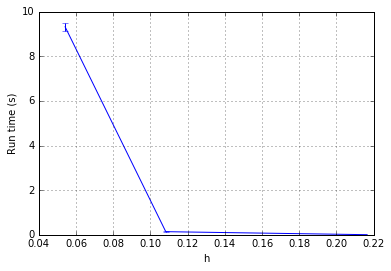

In [6]:
pylab.figure()
pylab.errorbar(hs, primal_lu_times, stds)
pylab.grid(True)
pylab.xlabel("h")
pylab.ylabel("Run time (s)")
pylab.show()

Or, we can look at run times versus problem size (number of degrees of freedom)

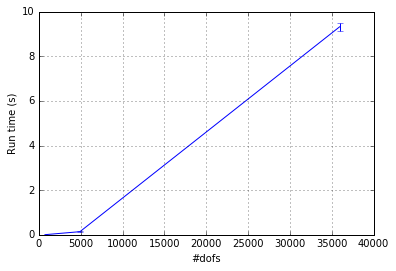

In [7]:
pylab.figure()
pylab.errorbar(Ns, primal_lu_times, stds)
pylab.grid(True)
pylab.xlabel("#dofs")
pylab.ylabel("Run time (s)")

pylab.show()

### Using AMG instead of LU for the primal formulation

Ok, so we can very easily do much better than using LU for this formulation. Since this is a symmetric and positive definite problem, an obvious choice is to use built-in CG (symmetric problem) with AMG preconditioning out of the box. Here is a short code snippet for doing so and timing the result: 

In [8]:
def primal_amg(mesh):
    "Solve primal H^1 formulation using CG with AMG."
    
    A, b, p = primal(mesh)
    
    tag = "Primal AMG"
    timer = Timer(tag)
    solver = PETScKrylovSolver("cg", "amg")
    solver.set_operator(A)
    num_it = solver.solve(p.vector(), b)
    timer.stop()

    print "%s: num_it = " % tag, num_it
    return (p, tag)

Let's do the same as we did for the LU, run some timings, and plot the results versus mesh size and problem size.Let's also try with N=64 since that should be completely feasible with an iterative solver.  

In [9]:
sizes = [8, 16, 32, 64]
hs = []
primal_amg_times = []
stds = []
Ns = []

R = 3

for n in sizes:
    mesh = UnitCubeMesh(n, n, n)
    Ns += [mesh.num_vertices()] # NB CG1 specific
    hs += [mesh.hmax()]
   
    avg_t, std_t = time_solves(mesh, primal_amg, R=R)
    print "%s took %0.3g (+- %0.3g)" % ("Primal AMG", avg_t, std_t)

    primal_amg_times += [avg_t]
    stds += [std_t]

Primal AMG: num_it =  3
<function primal_amg at 0x7fa7c70c95f0> (s) with N=729 and h=0.22: 0.011
Primal AMG: num_it =  3
<function primal_amg at 0x7fa7c70c95f0> (s) with N=729 and h=0.22: 0.0107
Primal AMG: num_it =  3
<function primal_amg at 0x7fa7c70c95f0> (s) with N=729 and h=0.22: 0.0101
Primal AMG took 0.0106 (+- 0.000368)
Primal AMG: num_it =  3
<function primal_amg at 0x7fa7c70c95f0> (s) with N=4913 and h=0.11: 0.107
Primal AMG: num_it =  3
<function primal_amg at 0x7fa7c70c95f0> (s) with N=4913 and h=0.11: 0.112
Primal AMG: num_it =  3
<function primal_amg at 0x7fa7c70c95f0> (s) with N=4913 and h=0.11: 0.113
Primal AMG took 0.111 (+- 0.00279)
Primal AMG: num_it =  3
<function primal_amg at 0x7fa7c70c95f0> (s) with N=35937 and h=0.054: 2.16
Primal AMG: num_it =  3
<function primal_amg at 0x7fa7c70c95f0> (s) with N=35937 and h=0.054: 2.08
Primal AMG: num_it =  3
<function primal_amg at 0x7fa7c70c95f0> (s) with N=35937 and h=0.054: 2.15
Primal AMG took 2.13 (+- 0.0374)
Primal AMG:

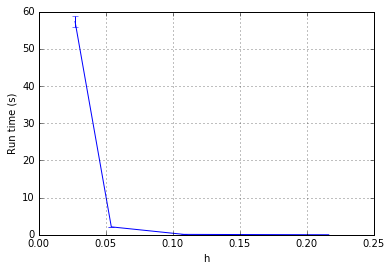

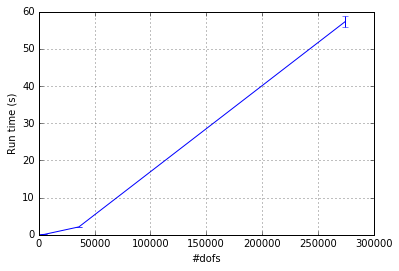

In [10]:
pylab.figure()
pylab.errorbar(hs, primal_amg_times, stds)
pylab.grid(True)
pylab.xlabel("h")
pylab.ylabel("Run time (s)")
pylab.show()

pylab.figure()
pylab.errorbar(Ns, primal_amg_times, stds)
pylab.grid(True)
pylab.xlabel("#dofs")
pylab.ylabel("Run time (s)")

pylab.show()

A quick look at these results indicates that 
* AMG beats LU run times around #dofs = 5000 (16 x 16 x 16 mesh) and onwards (increasing problem size);
* AMG run times increase with roughly a factor 20 when the mesh increases with a factor 10. 
* AMG for 32 x 32 x 32 takes about 2 seconds 
* Number of iterations seems pretty constant with increasing mesh size (3-4)

### Dependency on initial state

Does the initial state (value of p) make much of a difference for the iterative solver? Let's have a quick look at that.

In [11]:
n = 32
mesh = UnitCubeMesh(n, n, n)

A, b, p = primal(mesh)

tag = "Primal AMG with zero initial state"
timer = Timer(tag)
solver = PETScKrylovSolver("cg", "amg")
solver.set_operator(A)
num_it = solver.solve(p.vector(), b)
value = timer.stop()
print "%s (s) = " % tag, value

tag = "Primal AMG with random initial state"
dim = p.vector().size()
p.vector()[:] = numpy.random.rand(dim)
timer = Timer(tag)
solver = PETScKrylovSolver("cg", "amg")
solver.set_operator(A)
solver.parameters["nonzero_initial_guess"] = True
num_it = solver.solve(p.vector(), b)
value = timer.stop()
print "%s (s) = " % tag, value

Primal AMG with zero initial state (s) =  2.072976667
Primal AMG with random initial state (s) =  2.07263843


Nope, that does not seem to make much of a difference in this case.

## Implementation and exploration of the mixed formulation

In [12]:
def darcy(mesh):
    """Compute and return linear system and solution function 
    for mixed H(div) x L^2 formulation of Poisson/Darcy."""
    
    V = FiniteElement("RT", mesh.ufl_cell(), 1)
    Q = FiniteElement("DG", mesh.ufl_cell(), 0)
    W = FunctionSpace(mesh, V*Q)

    (u, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)

    a = (dot(u, v) + div(u)*q + div(v)*p)*dx
    f = Constant(-1.0)
    L = f*q*dx

    A = assemble(a)
    b = assemble(L)
    w = Function(W)

    return (A, b, w)

In [13]:
def darcy_lu(mesh):
    "Solve mixed H(div) x L^2 formulation using LU"
    
    tag = "Darcy LU"
    (A, b, w) = darcy(mesh)

    timer = Timer(tag)
    solver = LUSolver(A)
    solver.solve(w.vector(), b)
    timer.stop()
    
    #(u, p) = w.split(deepcopy=True)
    #plot(p)
    
    return (w, tag)

With this mixed variational formulation of the problem and the basic LU solver, let's run some similar experiments 

In [14]:
sizes = [8, 16]
hs = []
times = []
stds = []
Ns = []

R = 3

for n in sizes:
    mesh = UnitCubeMesh(n, n, n)
    mesh.init()
    Ns += [mesh.num_edges() + mesh.num_cells()] # NB: RT0 x DG0 specific
    hs += [mesh.hmax()]
   
    avg_t, std_t = time_solves(mesh, darcy_lu, R=R)
    print "%s took %0.3g (+- %0.3g)" % ("Darcy LU", avg_t, std_t)

    times += [avg_t]
    stds += [std_t]

<function darcy_lu at 0x7fa7c57085f0> (s) with N=9600 and h=0.22: 0.157
<function darcy_lu at 0x7fa7c57085f0> (s) with N=9600 and h=0.22: 0.133
<function darcy_lu at 0x7fa7c57085f0> (s) with N=9600 and h=0.22: 0.133
Darcy LU took 0.141 (+- 0.011)
<function darcy_lu at 0x7fa7c57085f0> (s) with N=75264 and h=0.11: 12.6
<function darcy_lu at 0x7fa7c57085f0> (s) with N=75264 and h=0.11: 13.1
<function darcy_lu at 0x7fa7c57085f0> (s) with N=75264 and h=0.11: 14
Darcy LU took 13.2 (+- 0.585)


Some observations:
* While LU for the primal formulation on the 8 x 8 x 8 mesh took 0.00537 s, LU for mixed on same mesh takes about 0.141 s which is a factor 20 increase. One can note however that N = 729 for the former and N = 9600 for the latter, which is a factor 10 increase in system size. 
* Running with 32 x 32 x 32 runs out of memory. 


This formulation is symmetric, but not positive definite (or negative definite), so it is not entirely clear how to proceed. One possibility is to try some out of the box iterative solvers anyway. So, let's start with that. 

Let's just start with "gmres" ("cg" gives garbage) and "ilu":

In [15]:
def darcy_ilu(mesh):
    "Solve mixed H(div) x L^2 formulation using GMRES and ilu"
    
    tag = "Darcy iLU"
    (A, b, w) = darcy(mesh)

    timer = Timer(tag)
    solver = PETScKrylovSolver("gmres", "ilu")
    solver.set_operator(A)
    num_iter = solver.solve(w.vector(), b)    
    timer.stop()

    print "#iterations (%s) = " % tag, num_iter
    
    return (w, tag)

One can experiment with this a bit, the results look reasonable, but the number of iterations increase with the system size:

In [16]:
sizes = [8, 16, 32]#, 64]
hs = []
times = []
stds = []
Ns = []

R = 2

for n in sizes:
    mesh = UnitCubeMesh(n, n, n)
    mesh.init()
    Ns += [mesh.num_edges() + mesh.num_cells()] # NB: RT0 x DG0 specific
    hs += [mesh.hmax()]
   
    avg_t, std_t = time_solves(mesh, darcy_ilu, R=R)
    print "%s took %0.3g (+- %0.3g)" % ("Darcy GMRES + iLU", avg_t, std_t)
    print

    times += [avg_t]
    stds += [std_t]

#iterations (Darcy iLU) =  49
<function darcy_ilu at 0x7fa7c5026ed8> (s) with N=9600 and h=0.22: 0.016
#iterations (Darcy iLU) =  49
<function darcy_ilu at 0x7fa7c5026ed8> (s) with N=9600 and h=0.22: 0.0151
Darcy GMRES + iLU took 0.0156 (+- 0.000468)

#iterations (Darcy iLU) =  190
<function darcy_ilu at 0x7fa7c5026ed8> (s) with N=75264 and h=0.11: 0.53
#iterations (Darcy iLU) =  190
<function darcy_ilu at 0x7fa7c5026ed8> (s) with N=75264 and h=0.11: 0.533
Darcy GMRES + iLU took 0.531 (+- 0.00154)

#iterations (Darcy iLU) =  575
<function darcy_ilu at 0x7fa7c5026ed8> (s) with N=595968 and h=0.054: 14.6
#iterations (Darcy iLU) =  575
<function darcy_ilu at 0x7fa7c5026ed8> (s) with N=595968 and h=0.054: 15.1
Darcy GMRES + iLU took 14.9 (+- 0.241)



Some observations regarding GMRES + iLU:
* Feasible solution range (in terms of number of degrees of freedom) greatly increased compared to LU, 64^3 is possible (but takes around 400 s with 1577 iterations).
* Cost per mesh size compared to primal formulation is about 6x for N=32 and increasing (about 8x for N=32) 
* Number of iterations increase significantly with mesh size.
* More testing required to examine correctness of solution for more complicated test cases.
* No tolerances set here, nor residual monitored, should do that. 

Ok, let's try if adding a preconditioner matrix helps with the AMG:

In [17]:
def darcy_prec1(W):
    (u, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)
    prec = (inner(u, v) + div(u)*div(v) + p*q)*dx
    B = assemble(prec)
    return B

def darcy_amg(mesh):
    """Solve mixed H(div) x L^2 formulation using GMRES and AMG, 
    with an additionally defined preconditioning matrix"""
    
    tag = "Darcy AMG"
    (A, b, w) = darcy(mesh)
    
    B = darcy_prec1(w.function_space())
    
    timer = Timer(tag)
    solver = PETScKrylovSolver("gmres", "amg") # or hypre_amg or petsc_amg
    solver.set_operators(A, B)
    solver.parameters["relative_tolerance"] = 1.e-10 # To get correct results in eye-norm 
    num_iter = solver.solve(w.vector(), b)    
    timer.stop()

    print "#iterations (%s) = " % tag, num_iter
    
    return (w, tag)

In [20]:
sizes = [8, 16]
hs = []
times = []
stds = []
Ns = []

R = 2

for n in sizes:
    mesh = UnitCubeMesh(n, n, n)
    mesh.init()
    Ns += [mesh.num_edges() + mesh.num_cells()] # NB: RT0 x DG0 specific
    hs += [mesh.hmax()]
   
    avg_t, std_t = time_solves(mesh, darcy_amg, R=R)
    print "%s took %0.3g (+- %0.3g)" % ("Darcy GMRES + AMG", avg_t, std_t)
    print

    times += [avg_t]
    stds += [std_t]

#iterations (Darcy AMG) =  255
<function darcy_amg at 0x7fa7c5029668> (s) with N=9600 and h=0.22: 0.713
#iterations (Darcy AMG) =  253
<function darcy_amg at 0x7fa7c5029668> (s) with N=9600 and h=0.22: 0.945
Darcy GMRES + AMG took 0.829 (+- 0.116)

#iterations (Darcy AMG) =  902
<function darcy_amg at 0x7fa7c5029668> (s) with N=75264 and h=0.11: 32.9
#iterations (Darcy AMG) =  800
<function darcy_amg at 0x7fa7c5029668> (s) with N=75264 and h=0.11: 30.5
Darcy GMRES + AMG took 31.7 (+- 1.23)



Observations
* The number of iterations is non-deterministic? What kind of deal is that??
* Large number of iterations and increasing with mesh size.
* Currently much slower than GMRES + iLU. 
* More understanding and tuning clearly needed.